In [90]:
import os
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score,f1_score, roc_curve, auc
import shap

In [57]:
rcParams['font.family']='Times New Roman'

In [58]:
entropy_grey = np.load('./results/entropy_grey.npy', allow_pickle=True)
entropy2d_grey = np.load('./results/entropy2d_grey.npy', allow_pickle=True)
entropy_hue = np.load('./results/entropy_hue.npy', allow_pickle=True)
tone_HSVs = np.load('./results/tone_HSVs.npy', allow_pickle=True)    # special handle
color_clusters = np.load('./results/color_clusters.npy', allow_pickle=True)
areas = np.load('./results/areas.npy', allow_pickle=True)
horizon_intervals = np.load('./results/horizon_intervals.npy', allow_pickle=True)
vertical_intervals = np.load('./results/vertival_intervals.npy', allow_pickle=True)

for feature in [entropy_grey, entropy2d_grey, entropy_hue, tone_HSVs, color_clusters, areas, horizon_intervals, vertical_intervals]:
    feature[0] = [v for i, v in enumerate(feature[0]) if i+1 not in {177,205,257,302}]
    feature[1] = [v for i, v in enumerate(feature[1]) if i+1 not in {78,79}]

features = [entropy_grey, entropy2d_grey, entropy_hue, color_clusters, areas, horizon_intervals, vertical_intervals]

In [59]:
def HSV2cone(points):
    points = points.copy().astype(np.double)
    points[:,0] = 2 * np.deg2rad(points[:,0])
    points[:,1] /=255; points[:,2] /= 255    # uniformization
    
    new_points = np.zeros(points.shape, dtype=np.double)
    points_sv = points[:, 1] * points[:, 2]
    
    new_points[:,0] = points_sv * np.cos(points[:, 0])
    new_points[:,1] = points_sv * np.sin(points[:, 0])
    new_points[:,2] = points[:, 2]
    return new_points

In [60]:
ASD_HSV = np.array(tone_HSVs[0])
TD_HSV = np.array(tone_HSVs[1])
ASD_XYZ = HSV2cone(ASD_HSV)
TD_XYZ = HSV2cone(TD_HSV)

In [61]:
tbs = [np.zeros(len(entropy_grey[0])).reshape(-1,1), np.zeros(len(entropy_grey[1])).reshape(-1,1)]

for j,feature in enumerate(features):
    for i in range(2):
        tbs[i] = np.hstack((tbs[i], np.array(feature[i]).reshape(-1,1)))
tbs = np.vstack((tbs[0][:,1:], tbs[1][:,1:]))

In [88]:
tb = pd.DataFrame(tbs)

tb['X'] = np.hstack((ASD_XYZ[:,0],TD_XYZ[:,0])).reshape(-1,1)
tb['Y'] = np.hstack((ASD_XYZ[:,1],TD_XYZ[:,1])).reshape(-1,1)
tb['Z'] = np.hstack((ASD_XYZ[:,2],TD_XYZ[:,2])).reshape(-1,1)
tb['label'] = np.vstack((np.ones(len(entropy_grey[0]), dtype=np.uint8).reshape(-1,1), np.zeros(len(entropy_grey[1]), dtype=np.uint8).reshape(-1,1)))
tb.columns = ['1D Gray Entropy', '2D Gray Entropy', '1D Hue Entropy', 'Color Richness', 'Relative Area', 'Horizontal Interval Metric', 'Vertical Interval Metric', 'Dominant Color X', 'Dominant Color Y', 'Dominant Color Z', 'label']
tb.to_csv('./results/all_features.csv', index=None)

In [89]:
tb

,1D Gray Entropy,2D Gray Entropy,1D Hue Entropy,Color Richness,Relative Area,Horizontal Interval Metric,Vertical Interval Metric,Dominant Color X,Dominant Color Y,Dominant Color Z,label
0,3.757319,8.199638,2.984306,4.0,0.180172,0.000000,0.006129,-0.022779,-0.031353,0.823529,1
1,4.714888,9.984443,4.135668,3.0,0.983521,0.001712,0.003144,-0.045593,-0.102404,0.772549,1
2,5.070659,10.304571,4.157235,4.0,0.995805,0.002059,0.004746,-0.014302,0.204529,0.396078,1
3,4.861554,9.968199,4.632747,4.0,0.995803,0.001441,0.002214,-0.034903,-0.078394,0.235294,1
4,4.831612,9.891949,4.300436,2.0,0.976716,0.001335,0.003850,-0.122485,0.230361,0.458824,1
...,...,...,...,...,...,...,...,...,...,...,...
530,4.472156,9.025126,3.321349,7.0,0.891165,0.000029,0.000040,-0.015255,-0.046950,0.839216,0
531,4.658013,8.932943,3.891208,3.0,0.931654,0.000442,0.000485,-0.009792,-0.034149,0.823529,0
532,4.726424,8.967950,4.560189,7.0,0.973873,0.003282,0.004204,0.058039,0.000000,0.870588,0
533,4.792121,9.414940,4.616940,5.0,0.973879,0.000788,0.001320,-0.032092,0.028895,0.211765,0


In [77]:
accuracy = []
precision = []
recall = []
F1 = []
AUC = []
fprs = []
tprs = []

kf = KFold(n_splits=5, shuffle=True, random_state=19260817)
for train_index, test_index in kf.split(tb):
    train_X = tb.iloc[:,:-1].iloc[train_index]
    test_X = tb.iloc[:,:-1].iloc[test_index]
    train_y = tb.iloc[:,-1][train_index]
    test_y = tb.iloc[:,-1][test_index]

    svm_clf = svm.SVC(kernel='rbf', gamma=0.6, probability=True)
    svm_clf.fit(train_X,train_y)
    test_prob = svm_clf.predict_proba(test_X)
    test_pred = svm_clf.predict(test_X)
    fpr, tpr, thresholds = roc_curve(test_y,test_prob[:,1], pos_label=1)
    
    fprs.append(fpr)
    tprs.append(tpr)
    
    accuracy.append(accuracy_score(test_y, test_pred))
    precision.append(precision_score(test_y, test_pred))
    recall.append(recall_score(test_y, test_pred))
    F1.append(f1_score(test_y, test_pred))
    AUC.append(auc(fpr,tpr))
print(np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(F1), np.mean(AUC))
print(np.std(accuracy), np.std(precision), np.std(recall), np.std(F1), np.std(AUC))

0.8598130841121495 0.864000465990934 0.9492866771347783 0.9045521932880399 0.9089650907132356
0.01182159872960142 0.014011416593053978 0.0103586902862562 0.009095546653007925 0.028410225478975176


In [84]:
svm_clf = svm.SVC(kernel='rbf', gamma=0.6, probability=True)
svm_clf.fit(tb.iloc[:,:-1],tb.iloc[:,-1])
valid_pred = svm_clf.predict(valid_tb.iloc[:,:-1])
valid_prob = svm_clf.predict_proba(valid_tb.iloc[:,:-1])
fpr, tpr, thresholds = roc_curve(valid_tb.iloc[:,-1],valid_prob[:,1], pos_label=1)

fprs.append(fpr)
tprs.append(tpr)

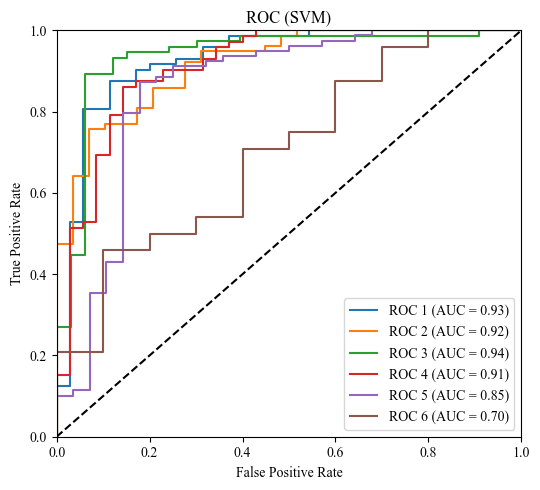

In [85]:
roc_aucs = []
for i in range(len(fprs)):
    roc_aucs.append(auc(fprs[i],tprs[i]))
fig = plt.figure(figsize = (5.5,5))
plt.title('ROC (SVM)')
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label = 'ROC %d (AUC = %0.2f)' % (i+1,roc_aucs[i]))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()
fig.savefig('roc1.svg')

In [92]:
valid_tb = pd.read_csv('./results/valid_all_features.csv')
valid_tb

,1D Gray Entropy,2D Gray Entropy,1D Hue Entropy,Color Richness,Relative Area,Horizontal Interval Metric,Vertical Interval Metric,Dominant Color X,Dominant Color Y,Dominant Color Z,label
0,1.057765,2.355009,2.984306,4.0,0.603691,0.002855,0.004579,-0.000000,0.000000,0.996078,1
1,3.190651,6.889010,4.135668,10.0,0.960619,0.001777,0.002574,0.000000,0.000000,0.988235,1
2,2.765383,6.024832,4.157235,7.0,0.938517,0.002572,0.002980,0.006573,0.004107,0.988235,1
3,2.217748,5.533011,4.632747,5.0,0.695489,0.001402,0.001468,-0.000000,0.000000,0.988235,1
4,2.423091,5.948474,4.300436,7.0,0.745724,0.001381,0.001389,0.002386,0.003054,0.988235,1
5,2.209020,5.404380,4.017312,5.0,0.851555,0.000883,0.001061,0.000000,0.000000,0.992157,1
6,2.673678,6.044106,2.846033,7.0,0.647294,0.002477,0.002281,0.012357,0.014726,0.980392,1
7,2.744171,6.551896,2.198130,4.0,0.901267,0.000720,0.001217,0.002386,0.003054,0.988235,1
8,2.273922,5.194957,3.323777,3.0,0.899065,0.002807,0.003555,0.002603,0.002891,0.992157,1
9,2.263381,5.180726,2.272553,4.0,0.899065,0.002778,0.003407,0.002603,0.002891,0.992157,1


In [93]:
svm_clf = svm.SVC(kernel='rbf', gamma=0.6, probability=True)
svm_clf.fit(tb.iloc[:,:-1],tb.iloc[:,-1])
valid_pred = svm_clf.predict(valid_tb.iloc[:,:-1])
valid_prob = svm_clf.predict_proba(valid_tb.iloc[:,:-1])
fpr, tpr, thresholds = roc_curve(valid_tb.iloc[:,-1],valid_prob[:,1], pos_label=1)
print(accuracy_score(valid_tb.iloc[:,-1], valid_pred), precision_score(valid_tb.iloc[:,-1], valid_pred), recall_score(valid_tb.iloc[:,-1], valid_pred), f1_score(valid_tb.iloc[:,-1], valid_pred), auc(fpr,tpr))

0.7647058823529411 0.75 1.0 0.8571428571428571 0.7


In [98]:
explainer = shap.KernelExplainer(svm_clf.predict,tb.iloc[:,:-1])
shap_values = explainer.shap_values(tb.iloc[:,:-1])
expected_values = explainer.expected_value
np.save('./results/svm_shap.npy', shap_values)
np.save('./results/svm_shap_exp.npy',expected_values)

Using 535 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/535 [00:00<?, ?it/s]

In [103]:
xgb_shap_values = np.load('./results/xgb_shap.npy', allow_pickle=True)
xgb_expected_values = np.load('./results/xgb_shap_exp.npy', allow_pickle=True)
svm_shap_values = np.load('./results/svm_shap.npy', allow_pickle=True)
svm_expected_values = np.load('./results/svm_shap_exp.npy', allow_pickle=True)

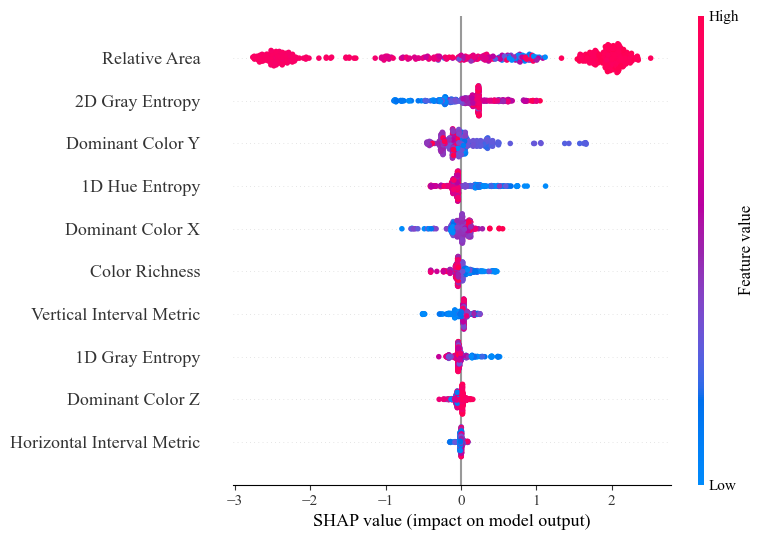

In [133]:
shap.summary_plot(xgb_shap_values, tb.iloc[:,:-1],show=False)
plt.savefig('xgb.svg', dpi=500)

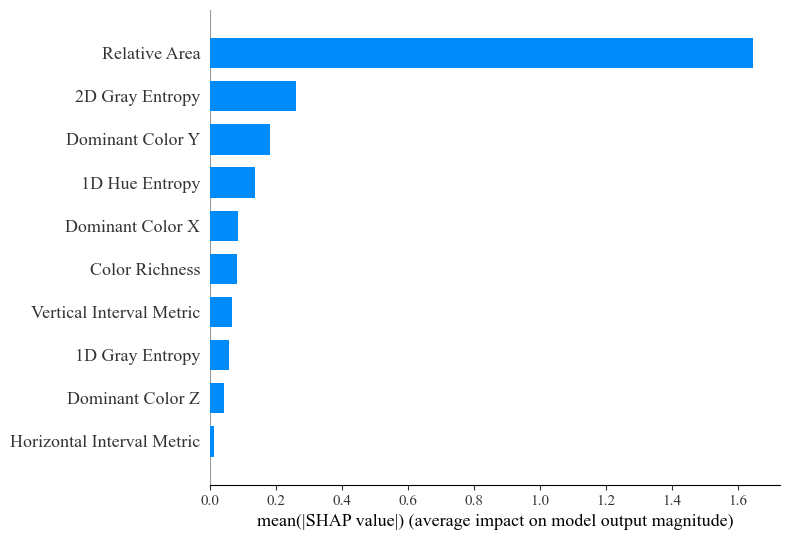

In [136]:
shap.summary_plot(xgb_shap_values, tb.iloc[:,:-1],show=False,plot_type='bar')
plt.savefig('xgb2.svg', dpi=500)

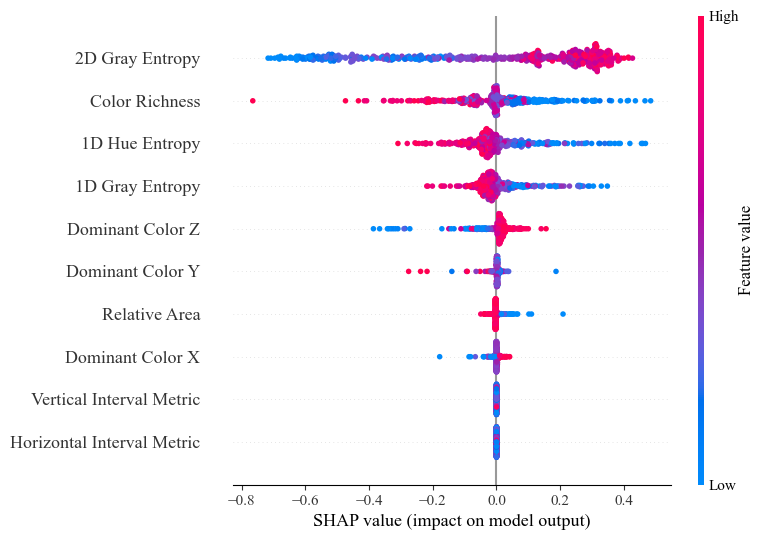

In [110]:
shap.summary_plot(svm_shap_values, tb.iloc[:,:-1],show=False)
plt.savefig('svm.svg', dpi=500)

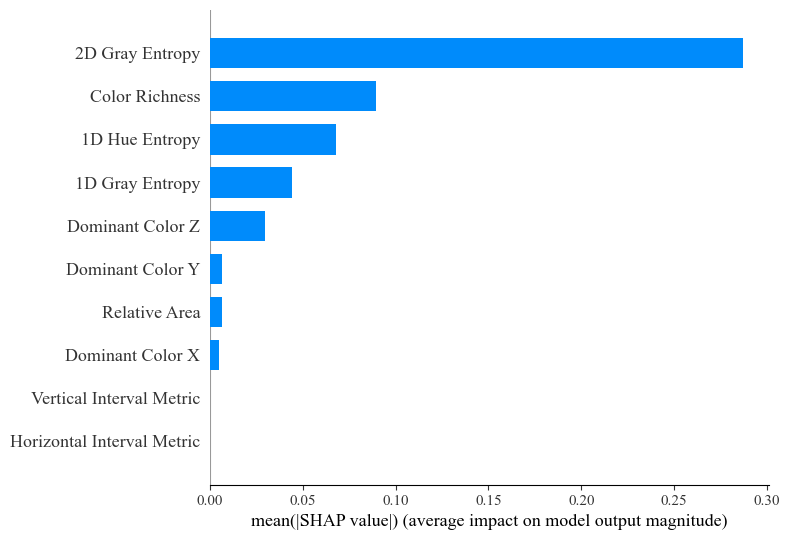

In [137]:
shap.summary_plot(svm_shap_values, tb.iloc[:,:-1],show=False,plot_type='bar')
plt.savefig('svm2.svg', dpi=500)

In [127]:
shap.initjs()
shap.plots.force(float(svm_expected_values),svm_shap_values,tb.iloc[:,:-1])

In [131]:
shap.initjs()
shap.plots.force(float(xgb_expected_values),xgb_shap_values,tb.iloc[:,:-1])